In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import random
import rasterio

sm.set_framework('tf.keras')
sm.framework()

from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

from sklearn import metrics

import math
import pandas as pd

import seaborn as sns

import ast

Segmentation Models: using `keras` framework.


### Prediction on different models

In [2]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [3]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip = False,
                      vertical_flip = False,
                      fill_mode = None)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        shuffle = False,
        target_size = (64, 64),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        shuffle = False,
        target_size = (64, 64),
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    # print(type(image_generator.filenames), type(mask_generator.filenames))
    # print(image_generator.filenames[:30])
    # train_files_index = list(image_generator.filenames)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [4]:
seed = 24
batch_size = 1
n_classes = 8

In [5]:
model_names = ['Unet-vgg19', 'Unet-resnet101', 'Unet-densenet121', 'FPN-densenet121', 'Linknet-resnet50']
models_path = '/home/shrayank_mistry/Modules/current_models/model_stats/'

In [6]:
models = []
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    models.append(load_model(models_path + f'{md}_{bk}/model.hdf5', compile = False))

In [7]:
models

In [8]:
test_img_path = '/home/shrayank_mistry/Modules/data_v2/test_images/'
test_msk_path = '/home/shrayank_mistry/Modules/data_v2/test_masks/'

test_images = os.listdir(test_img_path + 'test/')
test_masks = os.listdir(test_msk_path + 'test/')

test_images.sort()
test_masks.sort()

print(len(test_images), len(test_masks))

55917 55917


In [9]:
train_files_index = [str(i) for i in range(1, len(test_images) + 1)]
train_files_index.sort()

In [10]:
pred_paths = []
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    path = f'/home/shrayank_mistry/Modules/project_4413/{md}-{bk}/'
    # print(path)
    pred_paths.append(path)

In [11]:
pred_paths

['/home/shrayank_mistry/Modules/project_4413/Unet-vgg19/',
 '/home/shrayank_mistry/Modules/project_4413/Unet-resnet101/',
 '/home/shrayank_mistry/Modules/project_4413/Unet-densenet121/',
 '/home/shrayank_mistry/Modules/project_4413/FPN-densenet121/',
 '/home/shrayank_mistry/Modules/project_4413/Linknet-resnet50/']

In [12]:
# models = models[:1]
# models

# len(models)

In [13]:
index = 0
for i in range(len(models)):

    test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)
    predicted_path = pred_paths[i]

    print(predicted_path)

    for i in range(len(train_files_index)):
        # print(f'{predicted_path}{int(train_files_index[i])}.png')

        test_image_batch, test_mask_batch = test_img_gen.__next__()

        test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
        test_pred_batch = models[index].predict(test_image_batch)
        test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

        img = test_pred_batch_argmax[0]
        cv2.imwrite(f'{predicted_path}{int(train_files_index[i])}.png', img)


    index = index + 1

/home/shrayank_mistry/Modules/project_4413/Unet-vgg19/
Found 55917 images belonging to 1 classes.
Found 55917 images belonging to 1 classes.
/home/shrayank_mistry/Modules/project_4413/Unet-resnet101/
Found 55917 images belonging to 1 classes.
Found 55917 images belonging to 1 classes.
/home/shrayank_mistry/Modules/project_4413/Unet-densenet121/
Found 55917 images belonging to 1 classes.
Found 55917 images belonging to 1 classes.
/home/shrayank_mistry/Modules/project_4413/FPN-densenet121/
Found 55917 images belonging to 1 classes.
Found 55917 images belonging to 1 classes.
/home/shrayank_mistry/Modules/project_4413/Linknet-resnet50/
Found 55917 images belonging to 1 classes.
Found 55917 images belonging to 1 classes.


### Predicted Mask Mosaic Generation

In [21]:
path = '/home/shrayank_mistry/Modules/project_4413/raster.tif' 

data = rasterio.open(path)
print(data.bounds)

extent = data.bounds

left, bottom, right, top = extent[0], extent[1], extent[2], extent[3]
print(left, bottom, right, top)

BoundingBox(left=300000.0, bottom=1890240.0, right=409800.0, top=2100000.0)
300000.0 1890240.0 409800.0 2100000.0


In [22]:
test_img_path = '/home/shrayank_mistry/Modules/data_v2/test_images/'
test_images = os.listdir(test_img_path + 'test/')
file_names = [i for i in range(1, len(test_images) + 1)]

In [23]:
def build_area(model_name):

    R = 10944
    C = 20928
    index = 0

    main_arr = np.zeros((R, C))
    y = 0

    for i in range(327):
        x = 0
        for j in range(171):
            path = f'/home/shrayank_mistry/Modules/project_4413/{model_name}/{file_names[index]}.png'
            # arr = cv2.imread(f'/home/shrayank_mistry/Modules/{file_names[index]}.png', cv2.IMREAD_UNCHANGED)

            arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            # print(arr)
            a = 0

            for m in range(x, x + 64):
                b = 0
                for n in range(y, y + 64):
                    main_arr[m][n] = arr[a][b]
                    b = b + 1
                a = a + 1
            x = x + 64
            # print(path)
            index = index + 1
        y = y + 64
    return main_arr

In [24]:
areas = [build_area(mn) for mn in model_names]

In [34]:
path = '/home/shrayank_mistry/Modules/project_4413/raster.tif' 

data = rasterio.open(path)
print(data.bounds)

extent = data.bounds

left, bottom, right, top = extent[0], extent[1], extent[2], extent[3]
print(left, bottom, right, top)

BoundingBox(left=300000.0, bottom=1890240.0, right=409800.0, top=2100000.0)
300000.0 1890240.0 409800.0 2100000.0


In [15]:
test_img_path = '/home/shrayank_mistry/Modules/data_v2/test_images/'
test_images = os.listdir(test_img_path + 'test/')

In [16]:
len(test_images)

55917

In [36]:
file_names = [i for i in range(1, len(test_images) + 1)]

In [8]:
R = 10944
C = 20928
index = 0

main_arr = np.zeros((R, C))
y = 0

for i in range(327):
    x = 0
    for j in range(171):
        path = f'/home/shrayank_mistry/Modules/data_v2/predicted_masks/{file_names[index]}.png'
        # arr = cv2.imread(f'/home/shrayank_mistry/Modules/{file_names[index]}.png', cv2.IMREAD_UNCHANGED)

        arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # print(arr)
        a = 0

        for m in range(x, x + 64):
            b = 0
            for n in range(y, y + 64):
                main_arr[m][n] = arr[a][b]
                b = b + 1
            a = a + 1
        x = x + 64
        # print(path)
        index = index + 1
    y = y + 64

In [330]:
# cp_pred = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#0033cc', '#006600', '#33cc33', '#663300', '#5200cc', '#ffcc00', '#e68a00'])
cp_pred = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#0033cc', '#048A00', '#09FF01', '#5E02FF', '#813F00', '#FFFF02', '#FF9702'])

In [331]:
np.unique(main_arr, return_counts = True)

(array([1., 2., 3., 4., 5., 6., 7.]),
 array([14538540,  9675106, 35348038, 93836232,  9357376, 19132907,
        47147833]))

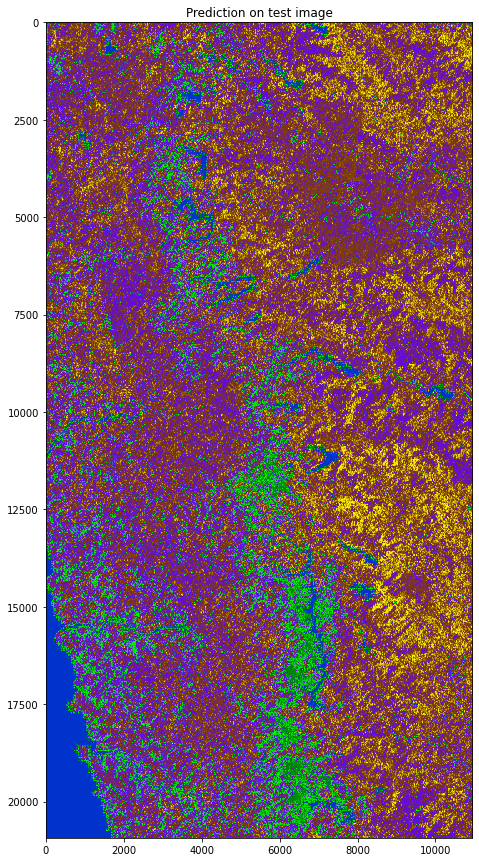

In [332]:
plt.figure(figsize=(20, 15))
plt.title('Prediction on test image')
plt.imshow(main_arr.T, cmap = cp_pred)
plt.show()

### Run From Here

In [129]:
w, h = 10944, 20928
points = 200
wpts = [np.random.randint(low = 0, high = w) for i in range(points)]
hpts = [np.random.randint(low = 0, high = h) for i in range(points)]

In [130]:
%%time
index = 0
ordinates_dict = {}


for i in range(len(wpts)): 
    pi, pj = wpts[index], hpts[index] 
    index = index + 1

    ext_i, ext_j = left + (pi * 10), top - (pj * 10)

    # ordinates_dict[(pi, pj)] = extent_matrix[pi][pj]
    ordinates_dict[pi, pj] = [ext_i, ext_j]

CPU times: user 117 µs, sys: 4 µs, total: 121 µs
Wall time: 124 µs


In [131]:
ordinates_dict
ordinates_list = []
for key, value in ordinates_dict.items():
    ordinates_list.append(value)

In [132]:
# ordinates_list

import shapefile
w = shapefile.Writer('gcps/test/multipoint')
w.field('name', 'C')

w.multipoint(ordinates_list) 
w.record('multipoint1')

w.close()

In [133]:
from osgeo import gdal

dataset = gdal.Open('/home/shrayank_mistry/Modules/project_4413/mask.tif', gdal.GA_ReadOnly)
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    main_msk = band.ReadAsArray(0)

main_msk = main_msk.T
main_msk = main_msk[:R, :C]
print(main_msk.shape)

(10944, 20928)


In [134]:
cls_dict_org = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

for i in range(len(wpts)):
    cl = main_msk[wpts[i], hpts[i]]
    cls_dict_org[cl] += 1

In [135]:
cls_dict_pred = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

for i in range(len(wpts)):
    cl = main_arr[wpts[i], hpts[i]]
    cls_dict_pred[cl] += 1

In [136]:
cls_dict_org

{0: 0, 1: 16, 2: 9, 3: 40, 4: 95, 5: 5, 6: 10, 7: 25}

In [137]:
cls_dict_pred

{0: 0, 1: 15, 2: 7, 3: 27, 4: 90, 5: 9, 6: 23, 7: 29}

In [138]:
print("Absolute Error Calculation")
error = 0
tpoints = 0

for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
    if k1 == 0:
        continue
    error   +=  np.round((abs(v2 - v1)))
    tpoints += v1

error = error / tpoints
print(f'Absolute Error = {error}')

Absolute Error Calculation
Absolute Error = 0.21


In [139]:
# classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
cls_dict = {1:'Water', 2:'DenseForests', 3:'SparseForests', 4:'BarrenLand', 5:'UrbanLand', 6:'FarmLand', 7:'Fallowland'}

In [140]:
print('Classwise difference in count')

for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
    if k1 == 0:
        continue
    print(f'{cls_dict[k1]} = {abs(v1 - v2)}')


Classwise difference in count
Water = 1
DenseForests = 2
SparseForests = 13
BarrenLand = 5
UrbanLand = 4
FarmLand = 13
Fallowland = 4


### Experiments

In [32]:
def get_point(m):

    pt = np.random.randint(low = 0, high = m)
    while (pt < 200 or pt > (m - 200)):
        pt = np.random.randint(low = 0, high = m)
    return pt

In [29]:
def gcp_randomizer(current_error):

    # Getting Random Points from study area
    w, h = 10944, 20928
    points = 200
    # wpts = [np.random.randint(low = 0, high = w) for i in range(points)]
    # hpts = [np.random.randint(low = 0, high = h) for i in range(points)]

    wpts = [get_point(w) for i in range(points)]
    hpts = [get_point(h) for i in range(points)]

    # Converting Pixel-Points to Co-ordinates
    index = 0
    ordinates_dict = {}

    for i in range(len(wpts)): 
        pi, pj = wpts[index], hpts[index] 
        index = index + 1

        ext_i, ext_j = left + (pi * 10), top - (pj * 10)
        ordinates_dict[pi, pj] = [ext_i, ext_j]
    
    ordinates_dict
    ordinates_list = []
    for key, value in ordinates_dict.items():
        ordinates_list.append(value)
    
    #Getting original-class for random-gcp-points 
    cls_dict_org = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

    for i in range(len(wpts)):
        cl = main_msk[wpts[i], hpts[i]]
        cls_dict_org[cl] += 1
    
    #Getting predicted-class for random-gcp-points 
    cls_dict_pred = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

    for i in range(len(wpts)):
        cl = main_arr[wpts[i], hpts[i]]
        cls_dict_pred[cl] += 1
    
    # Calculating Absolute Error
    # print("Absolute Error Calculation")
    error = 0
    tpoints = 0

    for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
        if k1 == 0:
            continue
        error   +=  np.round((abs(v2 - v1)))
        tpoints += v1

    error = np.round((error / tpoints), 2)
    # print(f'Absolute Error = {error}')

    if error <= current_error:
        # Creating shapefile for all co-ordinates for map-representation
        import shapefile
        w = shapefile.Writer('gcps/test/multipoint')
        w.field('name', 'C')

        w.multipoint(ordinates_list) 
        w.record('multipoint1')

        w.close()

    # Classwise-diff dict
    dlist = []
    for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
        if k1 == 0:
            continue
        # print(f'{cls_dict[k1]} = {abs(v1 - v2)}')
        dlist.append(abs(v1 - v2))
    
    return dlist, error


In [306]:
exp = 0
diff_list = []
errr_list = []

current_error = 1

while exp <= 10:
    d, e = gcp_randomizer(current_error)

    if e < 0.10:
        exp = exp + 1

        current_error = min(current_error, e)

        diff_list.append(d)
        errr_list.append(e)

In [307]:
diff_list

[[5, 2, 3, 2, 3, 2, 1],
 [0, 3, 1, 1, 2, 4, 1],
 [0, 1, 7, 3, 2, 0, 5],
 [3, 0, 1, 1, 4, 2, 3],
 [1, 1, 7, 1, 0, 0, 6],
 [1, 5, 3, 5, 1, 2, 1],
 [1, 1, 1, 5, 1, 1, 6],
 [1, 3, 2, 1, 3, 6, 2],
 [2, 1, 2, 1, 1, 4, 3],
 [2, 0, 2, 2, 1, 8, 3],
 [2, 2, 1, 2, 1, 5, 3]]

In [308]:
index = 1
error_dict = {}

average = 0
for i in range(exp):

    error_dict[f'Random-{index}'] = f'{np.round((errr_list[index - 1] * 100), 2)}%'
    average += errr_list[index - 1]

    index = index + 1

average = np.round((average / exp) * 100)

In [309]:
error_dict['Average'] = f'{average}%'

In [310]:
error_dict

{'Random-1': '9.0%',
 'Random-2': '6.0%',
 'Random-3': '9.0%',
 'Random-4': '7.0%',
 'Random-5': '8.0%',
 'Random-6': '9.0%',
 'Random-7': '8.0%',
 'Random-8': '9.0%',
 'Random-9': '7.0%',
 'Random-10': '9.0%',
 'Random-11': '8.0%',
 'Average': '8.0%'}

In [311]:
diff_dict = {}
index = 1
clss = ['Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
for i in range(exp):

    diff_dict[f'Random-{index}'] = diff_list[index - 1]
    index = index + 1

diff_df = pd.DataFrame(diff_dict, index = clss)

In [312]:
diff_df

,Random-1,Random-2,Random-3,Random-4,Random-5,Random-6,Random-7,Random-8,Random-9,Random-10,Random-11
Water,5,0,0,3,1,1,1,1,2,2,2
DenseForests,2,3,1,0,1,5,1,3,1,0,2
SparseForests,3,1,7,1,7,3,1,2,2,2,1
BarrenLand,2,1,3,1,1,5,5,1,1,2,2
UrbanLand,3,2,2,4,0,1,1,3,1,1,1
FarmLand,2,4,0,2,0,2,1,6,4,8,5
FallowLand,1,1,5,3,6,1,6,2,3,3,3


In [26]:
len(areas)

5

In [28]:
areas[0].shape, areas[1].shape, areas[2].shape, areas[3].shape, areas[4].shape

((10944, 20928),
 (10944, 20928),
 (10944, 20928),
 (10944, 20928),
 (10944, 20928))

In [38]:
from osgeo import gdal

R = 10944
C = 20928

dataset = gdal.Open('/home/shrayank_mistry/Modules/project_4413/mask.tif', gdal.GA_ReadOnly)
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    main_msk = band.ReadAsArray(0)

main_msk = main_msk.T
main_msk = main_msk[:R, :C]
print(main_msk.shape)

(10944, 20928)


#### Multiple-Model Comparison

In [44]:
exp = 1000
# Run 10 experiments per model
store_ordinates = []
model_error, model_diff = [[] for i in range(len(model_names))], [[] for i in range(len(model_names))]

for e in range(exp):
    # generate N random gcps
    N = 200

    current_errors = [1 for i in range(len(model_names))]

    w, h = 10944, 20928
    wpts = [get_point(w) for i in range(N)]
    hpts = [get_point(h) for i in range(N)]

    index = 0
    ordinates_dict = {}

    for i in range(len(wpts)): 
        pi, pj = wpts[index], hpts[index] 
        index = index + 1

        ext_i, ext_j = left + (pi * 10), top - (pj * 10)
        ordinates_dict[pi, pj] = [ext_i, ext_j]
    
    ordinates_dict
    ordinates_list = []
    for key, value in ordinates_dict.items():
        ordinates_list.append(value)

    store_ordinates.append(ordinates_list)
    mindex = -1
    for a in areas:

        mindex = mindex + 1
        #Getting original-class for random-gcp-points 
        cls_dict_org = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

        for i in range(len(wpts)):
            cl = main_msk[wpts[i], hpts[i]]
            cls_dict_org[cl] += 1
        
        #Getting predicted-class for random-gcp-points 
        cls_dict_pred = {0:0, 1:0 , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0}

        for i in range(len(wpts)):
            cl = a[wpts[i], hpts[i]]
            cls_dict_pred[cl] += 1
        
        # Calculating Absolute Error
        # print("Absolute Error Calculation")
        error = 0
        tpoints = 0

        for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
            if k1 == 0:
                continue
            error   +=  np.round((abs(v2 - v1)))
            tpoints += v1

        error = np.round((error / tpoints), 2)

        # Classwise-diff dict
        dlist = []
        for (k1,v1), (k2,v2) in zip(cls_dict_org.items(), cls_dict_pred.items()):
            if k1 == 0:
                continue
            # print(f'{cls_dict[k1]} = {abs(v1 - v2)}')
            dlist.append(abs(v1 - v2))
        
        model_error[mindex].append(error)
        model_diff[mindex].append(dlist)


In [ ]:
model_error[0]

In [49]:
track_index, id = [], 0
for e in model_error[0]:

    if e < 0.10:
        track_index.append(id)
    
    id = id + 1

In [56]:
len(track_index), len(store_ordinates)

(130, 1000)

In [ ]:
# data = {'row_1': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
# pd.DataFrame.from_dict(data, orient='index')
#        0  1  2  3
# row_1  3  2  1  0
# row_2  a  b  c  d

In [58]:
model_names

['Unet-vgg19',
 'Unet-resnet101',
 'Unet-densenet121',
 'FPN-densenet121',
 'Linknet-resnet50']

In [70]:
# ti = track_index[5:]
start, end = 15, 20

mcount = 5
error_dict = {}

for i in range(mcount):
    error_list = model_error[i]

    lt = []
    for j in track_index[start:end]:
        lt.append(error_list[j])
    
    error_dict[model_names[i]] = lt

In [71]:
error_dict

{'Unet-vgg19': [0.04, 0.09, 0.06, 0.09, 0.03],
 'Unet-resnet101': [0.15, 0.16, 0.14, 0.14, 0.09],
 'Unet-densenet121': [0.07, 0.14, 0.17, 0.11, 0.09],
 'FPN-densenet121': [0.17, 0.28, 0.24, 0.33, 0.14],
 'Linknet-resnet50': [0.13, 0.14, 0.11, 0.16, 0.08]}

In [72]:
pd.DataFrame.from_dict(error_dict, orient = 'index', columns = [f'Experiment{i + 1}' for i in range(5)])

,Experiment1,Experiment2,Experiment3,Experiment4,Experiment5
Unet-vgg19,0.04,0.09,0.06,0.09,0.03
Unet-resnet101,0.15,0.16,0.14,0.14,0.09
Unet-densenet121,0.07,0.14,0.17,0.11,0.09
FPN-densenet121,0.17,0.28,0.24,0.33,0.14
Linknet-resnet50,0.13,0.14,0.11,0.16,0.08


In [74]:
chosen_gcps = store_ordinates[track_index[20]]

In [75]:
import shapefile
w = shapefile.Writer('gcps/test/multipoint')
w.field('name', 'C')

w.multipoint(chosen_gcps) 
w.record('multipoint1')

w.close()

In [76]:
ti = track_index[15:20]

In [77]:
ti

[100, 121, 123, 135, 138]

In [78]:
mcount = 5
diff_dict = {}

for i in range(mcount):
    diff_list = model_diff[i]

    diff_dict[model_names[i]] = diff_list[138]

In [79]:
diff_dict

{'Unet-vgg19': [0, 2, 1, 1, 0, 1, 1],
 'Unet-resnet101': [1, 1, 1, 5, 3, 5, 2],
 'Unet-densenet121': [1, 1, 1, 6, 3, 5, 1],
 'FPN-densenet121': [1, 3, 0, 9, 4, 4, 7],
 'Linknet-resnet50': [0, 3, 1, 4, 3, 2, 3]}

In [80]:
# Dataframe for exp5
pd.DataFrame.from_dict(diff_dict, orient = 'index', columns = ['Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand'])

,Water,DenseForests,SparseForests,BarrenLand,UrbanLand,FarmLand,FallowLand
Unet-vgg19,0,2,1,1,0,1,1
Unet-resnet101,1,1,1,5,3,5,2
Unet-densenet121,1,1,1,6,3,5,1
FPN-densenet121,1,3,0,9,4,4,7
Linknet-resnet50,0,3,1,4,3,2,3
